In [37]:
from joblib import dump, load

import pandas as pd
import matplotlib.pyplot as plt

In [38]:
from src.const import DATA_HEAD, WEIGHTS_HEAD
ML_dir = WEIGHTS_HEAD / "ML"

data_filename = DATA_HEAD / "STORM_preprocessed_medianfill_1.csv"
base_df = pd.read_csv(str(data_filename), index_col=0)
base_df.head()

,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,OFDAResponse,Appeal,Declaration,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$),CPI
0,STORM_NAN_1953,NaN,1953,9,Storm,Tropical cyclone,8,0,0,0,0,0,92,989,1000,20,19400,211880,9.156133
1,STORM_VIOLET_1964,Violet,1964,9,Storm,Tropical cyclone,4,1,1,0,0,0,92,989,18,20,10000,94354,10.598376
2,STORM_IRIS_1964,Iris,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,150,960,5100,20,70000,660479,10.598376
3,STORM_JOAN_1964,Joan,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,130,980,2500,20,15000,141531,10.598376
4,STORM_KATE_1964,Kate,1964,11,Storm,Tropical cyclone,6,1,0,0,0,0,130,970,0,20,3000,28306,10.598376


In [39]:
SEED = 1


# I. Plan

1. **Featue importance**
2. **Categorical classification**
3. **damage prediction**

# 1. Feature importance

Using GBMs method to rank the attributes impact to the target base on its contribute <br>
[go to file](./GBMs.ipynb)

# 2. Categorical classification


| **Mô hình**               | **Ưu điểm**                            | **Nhược điểm**                          | **Khi nào dùng?**                       |
|---------------------------|----------------------------------------|----------------------------------------|----------------------------------------|
| Logistic Regression       | Đơn giản, dễ hiểu                      | Chỉ hiệu quả với dữ liệu tuyến tính    | Dữ liệu tuyến tính                     |
| KNN                       | Dễ triển khai                          | Dự đoán chậm với dữ liệu lớn           | Dữ liệu nhỏ, không tuyến tính          |
| Decision Tree             | Dễ trực quan hóa                       | Dễ bị overfitting                      | Phân loại nhanh                        |
| Random Forest             | Giảm overfitting                       | Tốn tài nguyên hơn Decision Tree       | Dữ liệu phức tạp                       |
| SVM                       | Hiệu quả với không gian chiều cao      | Khó mở rộng cho dữ liệu lớn            | Dữ liệu chiều cao                      |
| Naive Bayes               | Nhanh, hiệu quả                        | Giả định độc lập không luôn đúng       | Phân loại văn bản                      |
| Gradient Boosting         | Kết quả tốt                            | Tốn tài nguyên                         | Dữ liệu phức tạp, cần hiệu quả cao     |
| Neural Network (MLP)      | Học được mẫu phức tạp                  | Cần nhiều tài nguyên                   | Khi có nhiều dữ liệu                   |

**Model selection**
1. `Logistic Regression`
2. `KNN`
3. `Random Forest`
   - Random Forest works well with data that has both linear and non-linear features. 
   - It does not require normalization or transformation of the data (i.e., the data does not need to follow the same distribution). 
   - The model minimizes overfitting by aggregating from multiple decision trees.
4. `SVM with rbf or Polynomial kernel`
   - SVM with RBF or Polynomial kernel can turn non-linear data into linear in higher space. 
   - Suitable if data is moderate in size (SVM does not scale well for large data). 

## 2.1 SLIDE

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.const import CATEGORICAL_TARGETS, ATTRIBUTES

evaluate_dict = dict()

print(f"CATEGORICAL_TARGETS :{CATEGORICAL_TARGETS}")
print(f"ATTRIBUTES :{ATTRIBUTES}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES]
y = slide_df[CATEGORICAL_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled
X_test = X_test_scaled

print(f"Train size {len(X_train)}\n",y_train.value_counts())
print(f"Test size: {len(X_test)}\n",y_test.value_counts())

CATEGORICAL_TARGETS :['Flood', 'Slide']
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']
Train size 165
 Flood
1    139
0     26
Name: count, dtype: int64
Test size: 19
 Flood
1    14
0     5
Name: count, dtype: int64


In [41]:
epochs = 1000
thresh = 0.8

### 2.1.1 Logistic regression

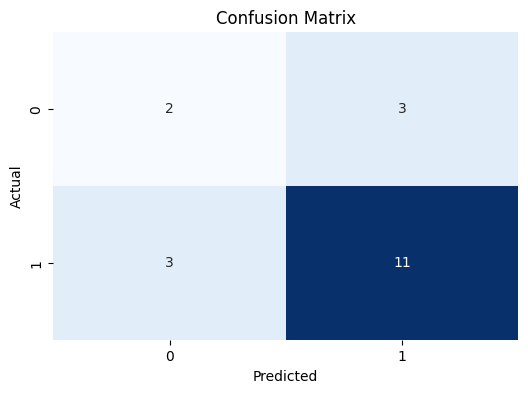

accuracy: 0.68
precision: 0.79
recall: 0.79


In [42]:
from sklearn.linear_model import LogisticRegression

from src.utils import evaluate, plot_confusion_matrix


slide_lr = LogisticRegression(max_iter=epochs, random_state=SEED)
slide_lr.fit(X_train, y_train)

eval_values = evaluate(slide_lr, X_test, y_test, threshold=thresh)
evaluate_dict[slide_lr.__class__.__name__] = eval_values

plot_confusion_matrix(eval_values['confusion_matrix'])
print(f"accuracy: {eval_values['accuracy']}")
print(f"precision: {eval_values['precision']}")
print(f"recall: {eval_values['recall']}")

### 2.1.2 KNN

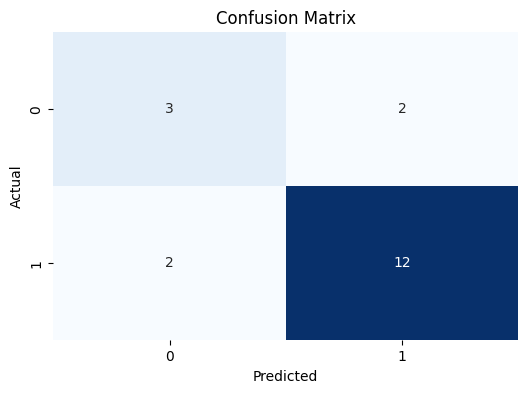

accuracy: 0.79
precision: 0.86
recall: 0.86


In [43]:
from sklearn.neighbors import KNeighborsClassifier

slide_knn = KNeighborsClassifier(n_neighbors=2)
slide_knn.fit(X_train, y_train)

eval_values = evaluate(slide_knn, X_test, y_test, threshold=thresh)
evaluate_dict[slide_knn.__class__.__name__] = eval_values

plot_confusion_matrix(eval_values['confusion_matrix'])
print(f"accuracy: {eval_values['accuracy']}")
print(f"precision: {eval_values['precision']}")
print(f"recall: {eval_values['recall']}")

### 2.1.3 Random Forest

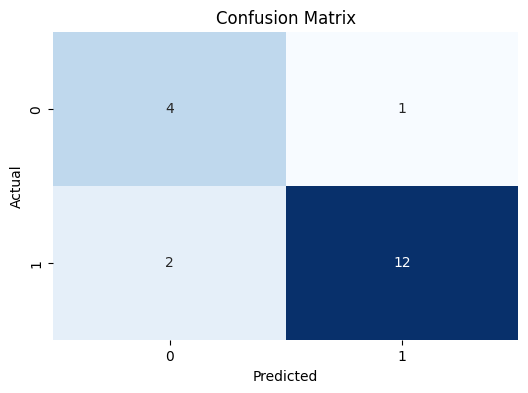

accuracy: 0.84
precision: 0.92
recall: 0.86


In [44]:
from sklearn.ensemble import RandomForestClassifier

slide_rf = RandomForestClassifier(n_estimators=epochs, random_state=SEED)
slide_rf.fit(X_train, y_train)

eval_values = evaluate(slide_rf, X_test, y_test, threshold=thresh)
evaluate_dict[slide_rf.__class__.__name__] = eval_values

plot_confusion_matrix(eval_values['confusion_matrix'])
print(f"accuracy: {eval_values['accuracy']}")
print(f"precision: {eval_values['precision']}")
print(f"recall: {eval_values['recall']}")

### 2.1.4 SVM with `rbf kernel`

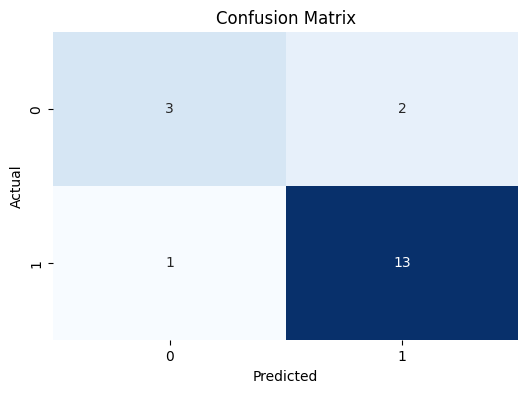

accuracy: 0.84
precision: 0.87
recall: 0.93


In [45]:
from sklearn.svm import SVC

slide_svm = SVC(kernel='rbf', random_state=SEED, probability=True, max_iter=epochs)
slide_svm.fit(X_train, y_train)

eval_values = evaluate(slide_svm, X_test, y_test, threshold=thresh)
evaluate_dict[slide_svm.__class__.__name__] = eval_values

plot_confusion_matrix(eval_values['confusion_matrix'])
print(f"accuracy: {eval_values['accuracy']}")
print(f"precision: {eval_values['precision']}")
print(f"recall: {eval_values['recall']}")

In [46]:
# compare metrics value
def highlight_max(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_row(row, selected_method):
    return ['background-color: black;' if row['Method'] in selected_method else '' 
            for _ in row]

selected_method = [slide_rf.__class__.__name__, slide_svm.__class__.__name__]
eval_value_df = pd.DataFrame(evaluate_dict).T.reset_index().rename(columns={"index":"Method"})

eval_value_df = (
    eval_value_df.style
    .apply(highlight_max, subset=["accuracy", "precision", "recall"])
    .apply(lambda row: highlight_row(row, selected_method), axis=1 )
    .format(precision=2)
)

eval_value_df

,Method,confusion_matrix,accuracy,precision,recall
0,LogisticRegression,[[ 2 3] [ 3 11]],0.68,0.79,0.79
1,KNeighborsClassifier,[[ 3 2] [ 2 12]],0.79,0.86,0.86
2,RandomForestClassifier,[[ 4 1] [ 2 12]],0.84,0.92,0.86
3,SVC,[[ 3 2] [ 1 13]],0.84,0.87,0.93


`Random Forest` and `SVM` archieve the good score in precision , recall and accuracy with same `1000 epoch` and `0.8 threshold for precision` because of <u>imbalance data</u>

In [47]:
dump(slide_rf, ML_dir / 'slide_predictor_random_forest.joblib')
dump(slide_svm, ML_dir / 'slide_predictor_svm.joblib')

['weights\\ML\\slide_predictor_svm.joblib']

## 2.2 FLOOD

In [48]:
# prepare

flood_df = base_df.copy()
X = flood_df[ATTRIBUTES]
y = flood_df[CATEGORICAL_TARGETS[1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train size {len(X_train)}\n",y_train.value_counts())
print(f"Test size: {len(X_test)}\n",y_test.value_counts())

Train size 165
 Slide
0    108
1     57
Name: count, dtype: int64
Test size: 19
 Slide
0    11
1     8
Name: count, dtype: int64


### Random Forest

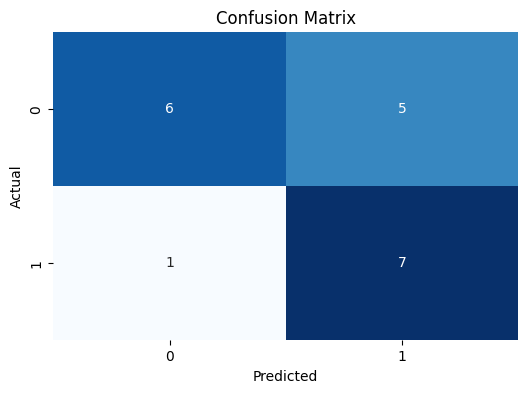

accuracy: 0.68
precision: 0.58
recall: 0.88


In [49]:
from sklearn.ensemble import RandomForestClassifier

flood_rf = RandomForestClassifier(n_estimators=epochs, random_state=SEED)
flood_rf.fit(X_train, y_train)

eval_values = evaluate(flood_rf, X_test, y_test, threshold=0.3)
# evaluate_dict[flood_rf.__class__.__name__] = eval_values

plot_confusion_matrix(eval_values['confusion_matrix'])
print(f"accuracy: {eval_values['accuracy']}")
print(f"precision: {eval_values['precision']}")
print(f"recall: {eval_values['recall']}")

In [50]:
dump(flood_rf, ML_dir / 'flood_predictor_random_forest.joblib')

['weights\\ML\\flood_predictor_random_forest.joblib']

# 3. Damage prediction

In [51]:
thresh = 0.3

## 3.1 NoDe*th

In [52]:
from src.const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[0]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled
X_test = X_test_scaled
print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")


LINEAR_TARGETS :TotalDeaths
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 165
Test size: 19


### 3.1.1 Multi Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression

# de*th_multilinearregression
d_mlr = LinearRegression()
d_mlr.fit(X_train, y_train)

eval_values = evaluate(d_mlr, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict["MultiLinearRegression"] = eval_values

eval_values

{'mae': 193.71,
 'mse': 68792.19,
 'rmse': 262.28,
 'mae_upperbound_tolerance': -177.9,
 'rmse_upperbound_tolerance': -240.98,
 'mse_upperbound_tolerance': -67279.06}

### 3.1.2 Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor

d_rf = RandomForestRegressor(n_estimators=epochs, random_state=SEED)
d_rf.fit(X_train, y_train)

eval_values = evaluate(d_rf, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict[d_rf.__class__.__name__] = eval_values

eval_values

{'mae': 219.28,
 'mse': 594628.47,
 'rmse': 771.12,
 'mae_upperbound_tolerance': -203.47,
 'rmse_upperbound_tolerance': -749.82,
 'mse_upperbound_tolerance': -593115.33}

### 3.1.3 SVR - Support Vector Regression

In [55]:
from sklearn.svm import SVR

d_svm = SVR(kernel="poly", max_iter=epochs)
d_svm.fit(X_train, y_train)

eval_values = evaluate(d_svm, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict[d_svm.__class__.__name__] = eval_values

eval_values

{'mae': 41.55,
 'mse': 5480.19,
 'rmse': 74.03,
 'mae_upperbound_tolerance': -25.75,
 'rmse_upperbound_tolerance': -52.72,
 'mse_upperbound_tolerance': -3967.05}

In [56]:
# compare metrics value
def highlight_max(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]

def highlight_row(row, selected_method):
    return ['background-color: black;' if row['Method'] in selected_method else '' 
            for _ in row]

selected_method = [d_svm.__class__.__name__]
eval_value_df = pd.DataFrame(evaluate_dict).T.reset_index().rename(columns={"index":"Method"})

eval_value_df = (
    eval_value_df.style
    .apply(highlight_max, subset=["mae_upperbound_tolerance", "rmse_upperbound_tolerance", "mse_upperbound_tolerance"])
    .apply(highlight_min, subset=["mae", "mse", "rmse"])
    .apply(lambda row: highlight_row(row, selected_method), axis=1 )
    .format(precision=2)
)

eval_value_df

,Method,mae,mse,rmse,mae_upperbound_tolerance,rmse_upperbound_tolerance,mse_upperbound_tolerance
0,MultiLinearRegression,193.71,68792.19,262.28,-177.90,-240.98,-67279.06
1,RandomForestRegressor,219.28,594628.47,771.12,-203.47,-749.82,-593115.33
2,SVR,41.55,5480.19,74.03,-25.75,-52.72,-3967.05


`SVR with poly kernel` perform `best` in all type of metrics

In [57]:
dump(d_svm, ML_dir / 'death_predictor_svm.joblib')

['weights\\ML\\death_predictor_svm.joblib']

## 3.2 NoInjured

In [58]:
from src.const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[1]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled
X_test = X_test_scaled
print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")


LINEAR_TARGETS :NoInjured
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 165
Test size: 19


### 3.2.1 Multi-Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression

# injured_multilinearregression
i_mlr = LinearRegression()
i_mlr.fit(X_train, y_train)

eval_values = evaluate(i_mlr, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict["MultiLinearRegression"] = eval_values

eval_values

{'mae': 90.13,
 'mse': 16567.38,
 'rmse': 128.71,
 'mae_upperbound_tolerance': -72.95,
 'rmse_upperbound_tolerance': -104.4,
 'mse_upperbound_tolerance': -14596.61}

### 3.2.2 Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

i_rf = RandomForestRegressor(n_estimators=epochs, random_state=SEED)
i_rf.fit(X_train, y_train)

eval_values = evaluate(i_rf, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict[i_rf.__class__.__name__] = eval_values

eval_values

{'mae': 60.18,
 'mse': 10606.89,
 'rmse': 102.99,
 'mae_upperbound_tolerance': -43.0,
 'rmse_upperbound_tolerance': -78.67,
 'mse_upperbound_tolerance': -8636.12}

### 3.2.3 SVR

In [61]:
from sklearn.svm import SVR

i_svm = SVR(kernel="poly", max_iter=epochs)
i_svm.fit(X_train, y_train)

eval_values = evaluate(i_svm, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict[i_svm.__class__.__name__] = eval_values

eval_values

{'mae': 40.31,
 'mse': 7390.26,
 'rmse': 85.97,
 'mae_upperbound_tolerance': -23.13,
 'rmse_upperbound_tolerance': -61.65,
 'mse_upperbound_tolerance': -5419.49}

In [62]:
# compare metrics value
def highlight_max(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]

def highlight_row(row, selected_method):
    return ['background-color: black;' if row['Method'] in selected_method else '' 
            for _ in row]

selected_method = [i_svm.__class__.__name__]
eval_value_df = pd.DataFrame(evaluate_dict).T.reset_index().rename(columns={"index":"Method"})

eval_value_df = (
    eval_value_df.style
    .apply(highlight_max, subset=["mae_upperbound_tolerance", "rmse_upperbound_tolerance", "mse_upperbound_tolerance"])
    .apply(highlight_min, subset=["mae", "mse", "rmse"])
    .apply(lambda row: highlight_row(row, selected_method), axis=1 )
    .format(precision=2)
)

eval_value_df

,Method,mae,mse,rmse,mae_upperbound_tolerance,rmse_upperbound_tolerance,mse_upperbound_tolerance
0,MultiLinearRegression,90.13,16567.38,128.71,-72.95,-104.40,-14596.61
1,RandomForestRegressor,60.18,10606.89,102.99,-43.00,-78.67,-8636.12
2,SVR,40.31,7390.26,85.97,-23.13,-61.65,-5419.49


`SVR with poly kernel` still be the best in all metric

In [63]:
dump(i_svm, ML_dir / 'injured_predictor_svm.joblib')

['weights\\ML\\injured_predictor_svm.joblib']

## 3.3 TotalDamageAdjusted

In [64]:
from src.const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[2]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[2]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train_scaled
X_test = X_test_scaled
print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")


LINEAR_TARGETS :TotalDamageAdjusted(000US$)
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 165
Test size: 19


### 3.3.1 Multi-Linear regression

In [65]:
from sklearn.linear_model import LinearRegression

# injured_multilinearregression
dmg_mlr = LinearRegression()
dmg_mlr.fit(X_train, y_train)

eval_values = evaluate(dmg_mlr, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict["MultiLinearRegression"] = eval_values

eval_values

{'mae': 100839.46,
 'mse': 21208388448.98,
 'rmse': 145631.0,
 'mae_upperbound_tolerance': -84409.01,
 'rmse_upperbound_tolerance': -118776.81,
 'mse_upperbound_tolerance': -18804563792.14}

### 3.3.2 Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

dmg_rf = RandomForestRegressor(n_estimators=epochs, random_state=SEED)
dmg_rf.fit(X_train, y_train)

eval_values = evaluate(dmg_rf, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict[dmg_rf.__class__.__name__] = eval_values

eval_values

{'mae': 88690.35,
 'mse': 16469344524.87,
 'rmse': 128332.94,
 'mae_upperbound_tolerance': -72259.9,
 'rmse_upperbound_tolerance': -101478.76,
 'mse_upperbound_tolerance': -14065519868.03}

### 3.3.3 SVR

In [67]:
from sklearn.svm import SVR

dmg_svm = SVR(kernel="poly", max_iter=epochs)
dmg_svm.fit(X_train, y_train)

eval_values = evaluate(dmg_svm, X_test, y_test, threshold=thresh, mode="regression")
evaluate_dict[dmg_svm.__class__.__name__] = eval_values

eval_values

{'mae': 52497.61,
 'mse': 8356010871.2,
 'rmse': 91411.22,
 'mae_upperbound_tolerance': -36067.17,
 'rmse_upperbound_tolerance': -64557.03,
 'mse_upperbound_tolerance': -5952186214.36}

In [68]:
# compare metrics value
def highlight_max(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]

def highlight_row(row, selected_method):
    return ['background-color: black;' if row['Method'] in selected_method else '' 
            for _ in row]

selected_method = [dmg_svm.__class__.__name__]
eval_value_df = pd.DataFrame(evaluate_dict).T.reset_index().rename(columns={"index":"Method"})

eval_value_df = (
    eval_value_df.style
    .apply(highlight_max, subset=["mae_upperbound_tolerance", "rmse_upperbound_tolerance", "mse_upperbound_tolerance"])
    .apply(highlight_min, subset=["mae", "mse", "rmse"])
    .apply(lambda row: highlight_row(row, selected_method), axis=1 )
    .format(precision=2)
)

eval_value_df

,Method,mae,mse,rmse,mae_upperbound_tolerance,rmse_upperbound_tolerance,mse_upperbound_tolerance
0,MultiLinearRegression,100839.46,21208388448.98,145631.00,-84409.01,-118776.81,-18804563792.14
1,RandomForestRegressor,88690.35,16469344524.87,128332.94,-72259.90,-101478.76,-14065519868.03
2,SVR,52497.61,8356010871.20,91411.22,-36067.17,-64557.03,-5952186214.36


In [69]:
dump(dmg_svm, ML_dir / 'damage_predictor_svm.joblib')

['weights\\ML\\damage_predictor_svm.joblib']